# Matching Anomalies to Astronomical Intuition

In [9]:
import os
# Set environment variables to disable multithreading
# as users will probably want to set the number of cores
# to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [10]:
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

from anomaly.constants import GALAXY_LINES
from anomaly.utils import specobjid_to_idx
from astroExplain.spectra.notebook import (
    interpret,
    explain_reconstruction_score,
)
from autoencoders.ae import AutoEncoder
from sdss.metadata import MetaData
from sdss.utils.managefiles import FileDirectory

meta = MetaData()

In [11]:
def explanation_name(lime_config: dict, fudge_config: dict) -> str:

    segmentation = lime_config["segmentation"]
    n_segments = lime_config["number_segments"]
    perturbation = fudge_config["kind_of_fudge"]

    explanation_str = f"{segmentation}_{n_segments}_{perturbation}"

    if perturbation == "scale":

        scale_factor = fudge_config["scale_factor"]
        explanation_str = f"{explanation_str}_{scale_factor}"

    return explanation_str

# Data ingestion

In [12]:
data_dir = "/home/elom/spectra"
model_dir = "/home/elom/models"
bin_id = "bin_03"
explanations_dir = f"{model_dir}/{bin_id}/explanation"
paper_figures_dir = "/home/elom/phd/00_paper_explain-me-why/sections/figures/"

In [13]:
meta_data_df = pd.read_csv(
    f"{data_dir}/0_01_z_0_5_4_0_snr_inf.csv.gz",
    index_col="specobjid",
)

In [14]:
wave = np.load(f"{data_dir}/wave_spectra_imputed.npy")

spectra = np.load(
    f"{data_dir}/spectra_imputed.npy",
    mmap_mode="r"
)

idx_id = np.load(
    f"{data_dir}/{bin_id}/{bin_id}_index_specobjid.npy"
)

## Load model

In [15]:
ae_model = AutoEncoder(
    reload=True,
    reload_from=f"{model_dir}/{bin_id}",
)

# MSE

## Strong emission lines

Set explainer and Get explanations
Get heat map of explanation
paper_figures_dir: /home/elom/phd/00_paper_explain-me-why/sections/figures//astro_intuition_xai/mse
phd_figures_dir: /home/elom/spectra/bin_03/mse_noRel100/sdss_images


/tmp/ipykernel_163866/1715869892.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=3240467000396376064&apid=


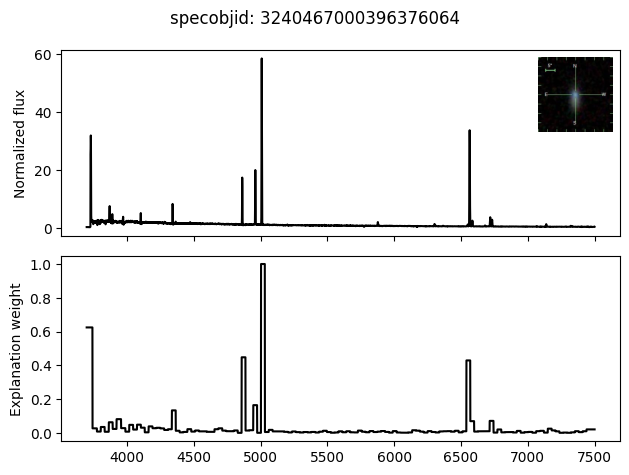

In [16]:
strong_emission_lines = {
    'specobjid': 3240467000396376064,
    'metric': 'mse_noRel100',
    'explanation': 'uniform_128_scale_0.9',
}

# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
    # if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}

lime_config = {
    "segmentation": "uniform",
    "number_segments": 128,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10_000,
}

fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}
# Get explanation for a specific specobjid
specobjid = strong_emission_lines["specobjid"]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)

fig.suptitle(f"specobjid: {specobjid}")

# Download sdss image and spectrum and explanation
from_score = strong_emission_lines["metric"]
save_for_paper_to = f"{paper_figures_dir}/astro_intuition_xai/mse"
save_for_phd_to = f"{data_dir}/{bin_id}/{from_score}/sdss_images"

# meta.download_sdss_spectrum_image(
#     specobjid=specobjid,
#     save_to=save_for_paper_to,
#     image_format="jpeg",
# )

# meta.download_sdss_spectrum_image(
#     specobjid=specobjid,
#     save_to=save_for_phd_to,
#     image_format="jpeg",
# )

# ra, dec = meta_data_df[['ra', 'dec']].loc[specobjid].values

# meta.get_sdss_image(
#     specobjid,
#     coordinates= (ra, dec),
#     save_to=save_for_paper_to,
#     image_format="jpeg",
# )

# meta.get_sdss_image(
#     specobjid,
#     coordinates= (ra, dec),
#     save_to=save_for_phd_to,
#     image_format="jpeg",
# )
print(f"paper_figures_dir: {save_for_paper_to}")
print(f"phd_figures_dir: {save_for_phd_to}")
image_name = f"image_{specobjid}.jpeg"
# Load the image
img = mpimg.imread(f"{save_for_paper_to}/{image_name}")

# Create inset in top-right corner of axs[0]
axins = inset_axes(
    axs[0],
    width=0.75, height=0.75,
    bbox_to_anchor=(1, 1),
    bbox_transform=axs[0].transAxes,
    loc="upper right"
    )

# Show image in the inset
axins.imshow(img)
axins.axis('off')  # Hide axis around the image
fig.tight_layout()

explanation_str = explanation_name(lime_config, fudge_config)

fig.savefig(
    f"{save_for_paper_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
fig.savefig(
    f"{save_for_phd_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
print(meta.get_sky_server_url(specobjid))


In [8]:
strong_emission_lines = {
    'specobjid': 3240467000396376064,
    'metric': 'mse_noRel100',
    'explanation': 'uniform_128_scale_0.9',
}

specobjid = strong_emission_lines["specobjid"]
meta_data_df.loc[specobjid]

mjd                   54465
plate                  2878
fiberid                 462
run2d                    26
ra                22.037619
dec               -9.481394
z                  0.021048
zErr               0.000004
zWarning                  0
class                GALAXY
subClass          STARBURST
z_noqso                   0
zErr_noqso                0
zWarning_noqso            0
targetType          SCIENCE
programname          legacy
instrument             SDSS
snMedian           20.35063
ABSSB             STARBURST
BROAD             STARBURST
ebv                0.030581
Name: 3240467000396376064, dtype: object

## bad data reduction

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=637325355518027776&apid=


/tmp/ipykernel_169736/1142847564.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


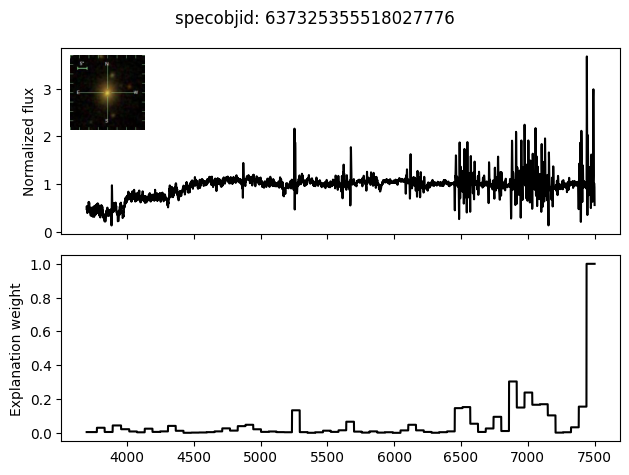

In [20]:
bad_data = {
    'specobjid': 637325355518027776,
    'metric': 'mse_noRel100',
    'explanation': 'uniform_64_scale_0.9',
}

# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
    # if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}

lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10_000,
}

fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = bad_data["specobjid"]

idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)

fig.suptitle(f"specobjid: {specobjid}")

# Download sdss image and spectrum and explanation
from_score = strong_emission_lines["metric"]
save_for_paper_to = f"{paper_figures_dir}/astro_intuition_xai/mse"
save_for_phd_to = f"{data_dir}/{bin_id}/{from_score}/sdss_images"

# meta.download_sdss_spectrum_image(
#     specobjid=specobjid,
#     save_to=save_for_paper_to,
#     image_format="jpeg",
# )

# meta.download_sdss_spectrum_image(
#     specobjid=specobjid,
#     save_to=save_for_phd_to,
#     image_format="jpeg",
# )

ra, dec = meta_data_df[['ra', 'dec']].loc[specobjid].values

# meta.get_sdss_image(
#     specobjid,
#     coordinates= (ra, dec),
#     save_to=save_for_paper_to,
#     image_format="jpeg",
# )

# meta.get_sdss_image(
#     specobjid,
#     coordinates= (ra, dec),
#     save_to=save_for_phd_to,
#     image_format="jpeg",
# )

image_name = f"image_{specobjid}.jpeg"
# Load the image
img = mpimg.imread(f"{save_for_paper_to}/{image_name}")

# Create inset in top-right corner of axs[0]
axins = inset_axes(
    axs[0],
    width=0.75, height=0.75,
    bbox_to_anchor=(0.163, 1),
    bbox_transform=axs[0].transAxes,
    loc="upper right"
    )

# Show image in the inset
axins.imshow(img)
axins.axis('off')  # Hide axis around the image
fig.tight_layout()

explanation_str = explanation_name(lime_config, fudge_config)

fig.savefig(
    f"{save_for_paper_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
fig.savefig(
    f"{save_for_phd_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
print(meta.get_sky_server_url(specobjid))


# MSE after ignoring 3%

## Blue shaped spectrum with absorsiton lines

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=531492683672217600&apid=


/tmp/ipykernel_169736/1649296475.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


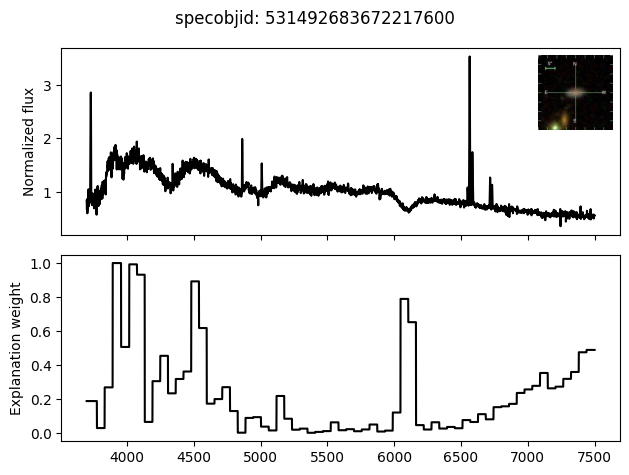

In [22]:
blue_shape = {
    'specobjid': 531492683672217600,
    'metric': 'mse_noRel97',
    'explanation': 'uniform_64_scale_0.9',
}

# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
    # if reconstruction
    "relative": False,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000,
}
fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = blue_shape["specobjid"]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)

fig.suptitle(f"specobjid: {specobjid}")

# Download sdss image and spectrum and explanation
from_score = strong_emission_lines["metric"]
save_for_paper_to = f"{paper_figures_dir}/astro_intuition_xai/mse"
save_for_phd_to = f"{data_dir}/{bin_id}/{from_score}/sdss_images"

# meta.download_sdss_spectrum_image(
#     specobjid=specobjid,
#     save_to=save_for_paper_to,
#     image_format="jpeg",
# )

# meta.download_sdss_spectrum_image(
#     specobjid=specobjid,
#     save_to=save_for_phd_to,
#     image_format="jpeg",
# )

# ra, dec = meta_data_df[['ra', 'dec']].loc[specobjid].values

# meta.get_sdss_image(
#     specobjid,
#     coordinates= (ra, dec),
#     save_to=save_for_paper_to,
#     image_format="jpeg",
# )

# meta.get_sdss_image(
#     specobjid,
#     coordinates= (ra, dec),
#     save_to=save_for_phd_to,
#     image_format="jpeg",
# )

image_name = f"image_{specobjid}.jpeg"
# Load the image
img = mpimg.imread(f"{save_for_paper_to}/{image_name}")

# Create inset in top-right corner of axs[0]
axins = inset_axes(
    axs[0],
    width=0.75, height=0.75,
    bbox_to_anchor=(1, 1),
    bbox_transform=axs[0].transAxes,
    loc="upper right"
    )

# Show image in the inset
axins.imshow(img)
axins.axis('off')  # Hide axis around the image
fig.tight_layout()

explanation_str = explanation_name(lime_config, fudge_config)

fig.savefig(
    f"{save_for_paper_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
fig.savefig(
    f"{save_for_phd_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
print(meta.get_sky_server_url(specobjid))


## Star

Set explainer and Get explanations
Get heat map of explanation


/tmp/ipykernel_169736/256180538.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=1780176998165932032&apid=


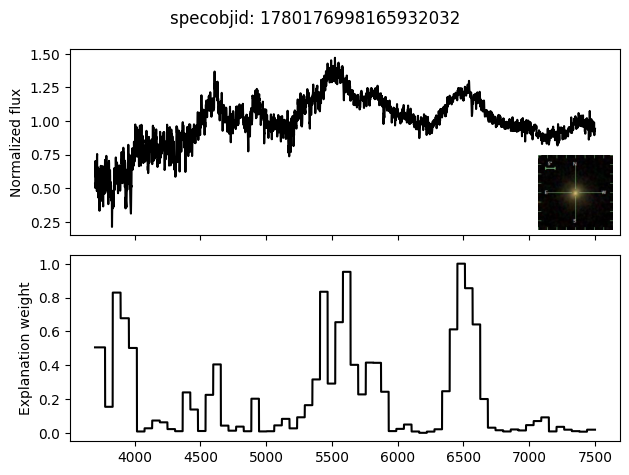

In [ ]:
star = {
    'specobjid': 1780176998165932032,
    'metric': 'mse_noRel97',
    'explanation': 'uniform_64_scale_0.9',
}

# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
    # if reconstruction
    "relative": False,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10_000,
}
fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = star["specobjid"]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)

fig.suptitle(f"specobjid: {specobjid}")

# Download sdss image and spectrum and explanation
from_score = strong_emission_lines["metric"]
save_for_paper_to = f"{paper_figures_dir}/astro_intuition_xai/mse"
save_for_phd_to = f"{data_dir}/{bin_id}/{from_score}/sdss_images"

# meta.download_sdss_spectrum_image(
#     specobjid=specobjid,
#     save_to=save_for_paper_to,
#     image_format="jpeg",
# )

# meta.download_sdss_spectrum_image(
#     specobjid=specobjid,
#     save_to=save_for_phd_to,
#     image_format="jpeg",
# )

# ra, dec = meta_data_df[['ra', 'dec']].loc[specobjid].values

# meta.get_sdss_image(
#     specobjid,
#     coordinates= (ra, dec),
#     save_to=save_for_paper_to,
#     image_format="jpeg",
# )

# meta.get_sdss_image(
#     specobjid,
#     coordinates= (ra, dec),
#     save_to=save_for_phd_to,
#     image_format="jpeg",
# )

image_name = f"image_{specobjid}.jpeg"
# Load the image
img = mpimg.imread(f"{save_for_paper_to}/{image_name}")

# Create inset in top-right corner of axs[0]
axins = inset_axes(
    axs[0],
    width=0.75, height=0.75,
    bbox_to_anchor=(1, 0.47),
    bbox_transform=axs[0].transAxes,
    loc="upper right"
    )

# Show image in the inset
axins.imshow(img)
axins.axis('off')  # Hide axis around the image
fig.tight_layout()

explanation_str = explanation_name(lime_config, fudge_config)

fig.savefig(
    f"{save_for_paper_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
fig.savefig(
    f"{save_for_phd_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
print(meta.get_sky_server_url(specobjid))


# MSE with 250 kms-1 filter

## Broad line and strong emission

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=1924292192684238848&apid=


/tmp/ipykernel_169736/3238120051.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


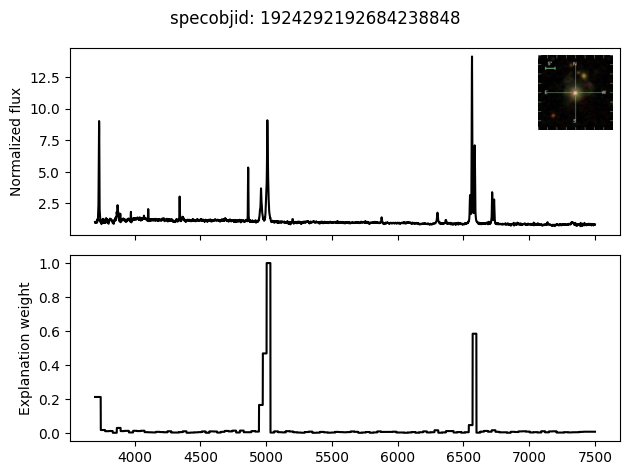

In [28]:
broad_line = {
    'specobjid':1924292192684238848 ,
    'metric': 'mse_filter_250kms_noRel100',
    'explanation': 'uniform_128_scale_0.9',
}

# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
    # if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 128,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000,
}
fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = broad_line["specobjid"]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)

fig.suptitle(f"specobjid: {specobjid}")

# Download sdss image and spectrum and explanation
from_score = strong_emission_lines["metric"]
save_for_paper_to = f"{paper_figures_dir}/astro_intuition_xai/mse"
save_for_phd_to = f"{data_dir}/{bin_id}/{from_score}/sdss_images"

# meta.download_sdss_spectrum_image(
#     specobjid=specobjid,
#     save_to=save_for_paper_to,
#     image_format="jpeg",
# )

# meta.download_sdss_spectrum_image(
#     specobjid=specobjid,
#     save_to=save_for_phd_to,
#     image_format="jpeg",
# )

# ra, dec = meta_data_df[['ra', 'dec']].loc[specobjid].values

# meta.get_sdss_image(
#     specobjid,
#     coordinates= (ra, dec),
#     save_to=save_for_paper_to,
#     image_format="jpeg",
# )

# meta.get_sdss_image(
#     specobjid,
#     coordinates= (ra, dec),
#     save_to=save_for_phd_to,
#     image_format="jpeg",
# )

image_name = f"image_{specobjid}.jpeg"
# Load the image
img = mpimg.imread(f"{save_for_paper_to}/{image_name}")

# Create inset in top-right corner of axs[0]
axins = inset_axes(
    axs[0],
    width=0.75, height=0.75,
    bbox_to_anchor=(1, 1),
    bbox_transform=axs[0].transAxes,
    loc="upper right"
    )

# Show image in the inset
axins.imshow(img)
axins.axis('off')  # Hide axis around the image
fig.tight_layout()

explanation_str = explanation_name(lime_config, fudge_config)

fig.savefig(
    f"{save_for_paper_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
fig.savefig(
    f"{save_for_phd_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
print(meta.get_sky_server_url(specobjid))


## Spectrum with a glitch

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=407686575611209728&apid=


/tmp/ipykernel_169736/272376428.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


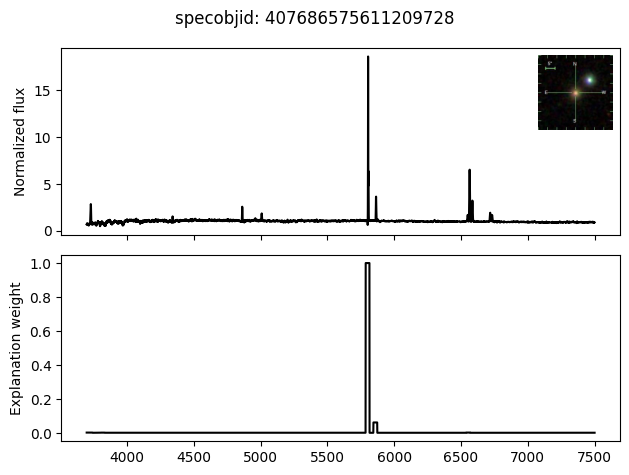

In [30]:
cosmic = {
    'specobjid': 407686575611209728,
    'metric': 'mse_filter_250kms_noRel100',
    'explanation': 'uniform_64_scale_0.9',
}

# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
    # if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 128,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000,
}
fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = cosmic["specobjid"]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)

fig.suptitle(f"specobjid: {specobjid}")

# Download sdss image and spectrum and explanation
from_score = strong_emission_lines["metric"]
save_for_paper_to = f"{paper_figures_dir}/astro_intuition_xai/mse"
save_for_phd_to = f"{data_dir}/{bin_id}/{from_score}/sdss_images"

# meta.download_sdss_spectrum_image(
#     specobjid=specobjid,
#     save_to=save_for_paper_to,
#     image_format="jpeg",
# )

# meta.download_sdss_spectrum_image(
#     specobjid=specobjid,
#     save_to=save_for_phd_to,
#     image_format="jpeg",
# )

# ra, dec = meta_data_df[['ra', 'dec']].loc[specobjid].values

# meta.get_sdss_image(
#     specobjid,
#     coordinates= (ra, dec),
#     save_to=save_for_paper_to,
#     image_format="jpeg",
# )

# meta.get_sdss_image(
#     specobjid,
#     coordinates= (ra, dec),
#     save_to=save_for_phd_to,
#     image_format="jpeg",
# )

image_name = f"image_{specobjid}.jpeg"
# Load the image
img = mpimg.imread(f"{save_for_paper_to}/{image_name}")

# Create inset in top-right corner of axs[0]
axins = inset_axes(
    axs[0],
    width=0.75, height=0.75,
    bbox_to_anchor=(1, 1),
    bbox_transform=axs[0].transAxes,
    loc="upper right"
    )

# Show image in the inset
axins.imshow(img)
axins.axis('off')  # Hide axis around the image
fig.tight_layout()

explanation_str = explanation_name(lime_config, fudge_config)

fig.savefig(
    f"{save_for_paper_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
fig.savefig(
    f"{save_for_phd_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
print(meta.get_sky_server_url(specobjid))


# MSE with 250 kms-1 filter after ignoring 3%

## broad near H alpha

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2664004586678806528&apid=


/tmp/ipykernel_169736/1009068900.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


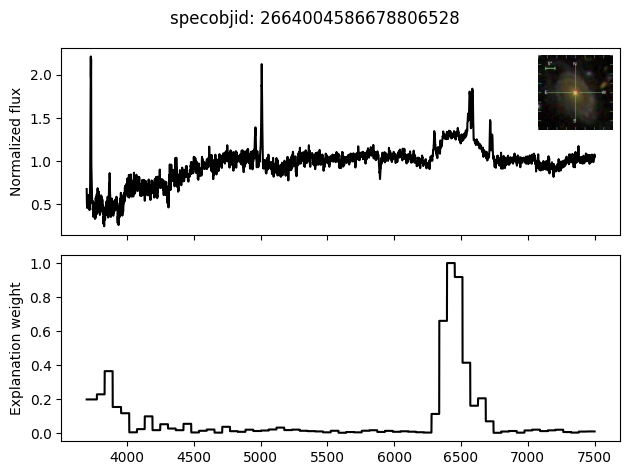

In [ ]:
broad_near_halpha = {
    'specobjid': 2664004586678806528,
    'metric': 'mse_filter_250kms_noRel97',
    'explanation': 'uniform_64_scale_0.9',
}

# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
    # if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000,
}
fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = broad_near_halpha["specobjid"]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)

fig.suptitle(f"specobjid: {specobjid}")

# Download sdss image and spectrum and explanation
from_score = strong_emission_lines["metric"]
save_for_paper_to = f"{paper_figures_dir}/astro_intuition_xai/mse"
save_for_phd_to = f"{data_dir}/{bin_id}/{from_score}/sdss_images"

# meta.download_sdss_spectrum_image(
#     specobjid=specobjid,
#     save_to=save_for_paper_to,
#     image_format="jpeg",
# )

# meta.download_sdss_spectrum_image(
#     specobjid=specobjid,
#     save_to=save_for_phd_to,
#     image_format="jpeg",
# )

# ra, dec = meta_data_df[['ra', 'dec']].loc[specobjid].values

# meta.get_sdss_image(
#     specobjid,
#     coordinates= (ra, dec),
#     save_to=save_for_paper_to,
#     image_format="jpeg",
# )

# meta.get_sdss_image(
#     specobjid,
#     coordinates= (ra, dec),
#     save_to=save_for_phd_to,
#     image_format="jpeg",
# )

image_name = f"image_{specobjid}.jpeg"
# Load the image
img = mpimg.imread(f"{save_for_paper_to}/{image_name}")

# Create inset in top-right corner of axs[0]
axins = inset_axes(
    axs[0],
    width=0.75, height=0.75,
    bbox_to_anchor=(1, 1),
    bbox_transform=axs[0].transAxes,
    loc="upper right"
    )

# Show image in the inset
axins.imshow(img)
axins.axis('off')  # Hide axis around the image
fig.tight_layout()

explanation_str = explanation_name(lime_config, fudge_config)

fig.savefig(
    f"{save_for_paper_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
fig.savefig(
    f"{save_for_phd_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
print(meta.get_sky_server_url(specobjid))


## bumpy spectrum

Set explainer and Get explanations
Get heat map of explanation


/tmp/ipykernel_169736/1751341110.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2501881598136313856&apid=


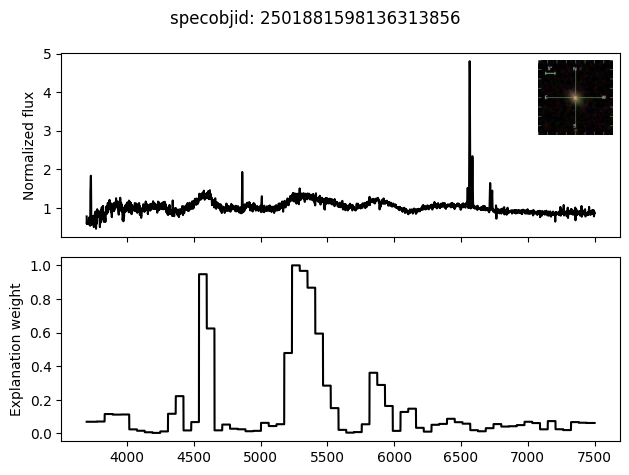

In [33]:
bumpy = {
    'specobjid': 2501881598136313856,
    'metric': 'mse_filter_250kms_noRel97',
    'explanation': 'uniform_64_scale_0.9',
}
# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
    # if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000,
}
fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = bumpy["specobjid"]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)

fig.suptitle(f"specobjid: {specobjid}")

# Download sdss image and spectrum and explanation
from_score = strong_emission_lines["metric"]
save_for_paper_to = f"{paper_figures_dir}/astro_intuition_xai/mse"
save_for_phd_to = f"{data_dir}/{bin_id}/{from_score}/sdss_images"

meta.download_sdss_spectrum_image(
    specobjid=specobjid,
    save_to=save_for_paper_to,
    image_format="jpeg",
)

meta.download_sdss_spectrum_image(
    specobjid=specobjid,
    save_to=save_for_phd_to,
    image_format="jpeg",
)

ra, dec = meta_data_df[['ra', 'dec']].loc[specobjid].values

meta.get_sdss_image(
    specobjid,
    coordinates= (ra, dec),
    save_to=save_for_paper_to,
    image_format="jpeg",
)

meta.get_sdss_image(
    specobjid,
    coordinates= (ra, dec),
    save_to=save_for_phd_to,
    image_format="jpeg",
)

image_name = f"image_{specobjid}.jpeg"
# Load the image
img = mpimg.imread(f"{save_for_paper_to}/{image_name}")

# Create inset in top-right corner of axs[0]
axins = inset_axes(
    axs[0],
    width=0.75, height=0.75,
    bbox_to_anchor=(1, 1),
    bbox_transform=axs[0].transAxes,
    loc="upper right"
    )

# Show image in the inset
axins.imshow(img)
axins.axis('off')  # Hide axis around the image
fig.tight_layout()

explanation_str = explanation_name(lime_config, fudge_config)

fig.savefig(
    f"{save_for_paper_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
fig.savefig(
    f"{save_for_phd_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
)
print(meta.get_sky_server_url(specobjid))
